### Create dataset from the cityscape files

In [1]:
import numpy as np
%run cityscape_dataset_maker.ipynb

In [2]:
get_images('D:\\cityscape\\leftImg8bit\\val','D:\\cityscape\\gtFine\\val')

In [3]:
cars_array, pedestrians_array, others_array, others_labels_array = dataset_maker()

In [4]:
def resize_images(array, new_dim):
    resized_array = []
    for i in range(array.shape[0]):
        resized_array.append(cv2.resize(array[i], new_dim))
    return np.array(resized_array)

In [5]:
img_size = 96


cars_array = resize_images(cars_array, (img_size,img_size))
pedestrians_array = resize_images(pedestrians_array, (img_size,img_size))
others_array = resize_images(others_array, (img_size,img_size))

(1434, 96, 96, 3)


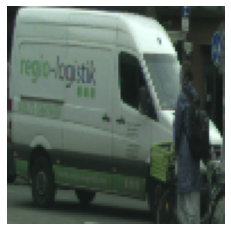

In [6]:
print(cars_array.shape)
plt.axis("off")
plt.imshow(cars_array[np.random.randint(0,cars_array.shape[0])])

(351, 96, 96, 3)


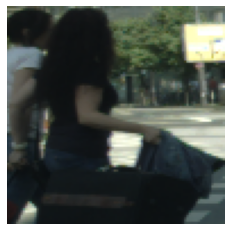

In [71]:
print(pedestrians_array.shape)
plt.axis("off")
plt.imshow(pedestrians_array[np.random.randint(0,pedestrians_array.shape[0])])

(5586, 96, 96, 3)
pole


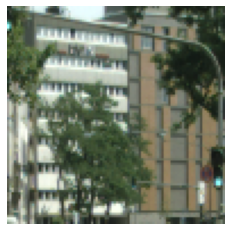

In [81]:
print(others_array.shape)
plt.axis("off")
random_index = np.random.randint(0,others_array.shape[0])
print(others_labels_array[random_index])
plt.imshow(others_array[random_index])

In [9]:
#arrays of images to training set
X_train = np.concatenate((cars_array, pedestrians_array, others_array), axis=0)
y_train = np.concatenate((np.zeros(cars_array.shape[0]), np.ones(pedestrians_array.shape[0]), np.full(others_array.shape[0],2)), axis=0)

In [10]:
from tensorflow.keras.utils import to_categorical
# to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)

In [11]:
#shuffle the data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [12]:
#split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

### Convolutive Neural Networks

In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2453454771353290500
xla_global_id: -1
]


In [15]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

In [16]:
num_classes = 3

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(img_size,img_size,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [18]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                    

In [83]:
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
208/208 [==============================] - 66s 316ms/step - loss: 0.4183 - accuracy: 0.9028 - val_loss: 0.3149 - val_accuracy: 0.9133
Epoch 2/10
208/208 [==============================] - 59s 282ms/step - loss: 0.3337 - accuracy: 0.9159 - val_loss: 0.3522 - val_accuracy: 0.9160
Epoch 3/10
208/208 [==============================] - 57s 272ms/step - loss: 0.3892 - accuracy: 0.9107 - val_loss: 0.4326 - val_accuracy: 0.9133
Epoch 4/10
208/208 [==============================] - 55s 264ms/step - loss: 0.3274 - accuracy: 0.9231 - val_loss: 0.3536 - val_accuracy: 0.9106
Epoch 5/10
208/208 [==============================] - 54s 260ms/step - loss: 0.2685 - accuracy: 0.9350 - val_loss: 0.4002 - val_accuracy: 0.9173
Epoch 6/10
208/208 [==============================] - 57s 275ms/step - loss: 0.2950 - accuracy: 0.9331 - val_loss: 0.5195 - val_accuracy: 0.9201
Epoch 7/10
208/208 [==============================] - 58s 277ms/step - loss: 0.1717 - accuracy: 0.9540 - val_loss: 0.4256 - val_ac

In [90]:
model.save('../model/model_id_cityscape.h5')

## Testing

Text(0.5, 0, 'epoch')

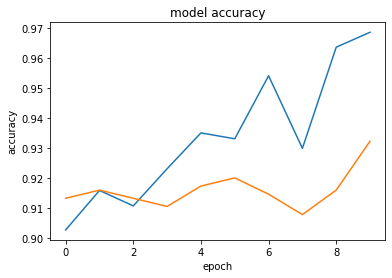

In [84]:
#graph accuracy vs val_accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [91]:
target_names = ['cars', 'pedestrians', 'others']

In [93]:
from sklearn.metrics import classification_report
predictions = model.predict(X_val)
predictions = np.argmax(predictions, axis=1)
y_val = np.argmax(y_val, axis=1)
print(classification_report(y_val, predictions, target_names=target_names))

              precision    recall  f1-score   support

        cars       0.85      0.91      0.88       152
 pedestrians       0.79      0.70      0.74        37
      others       0.97      0.95      0.96       549

    accuracy                           0.93       738
   macro avg       0.87      0.86      0.86       738
weighted avg       0.93      0.93      0.93       738

